## Load data

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

plt.style.use('seaborn-v0_8-paper')

function which install pip packages if they are not installed.
In this way we can import librosa

In [15]:
def load_data(phase, path = os.getcwd()):
    if phase == "dev":
        data_path = os.path.join("dsl_data", "development.csv")
    elif phase == "eval":
        data_path = os.path.join("dsl_data", "evaluation.csv")
    else:
        raise Exception(f"Error - phase '{phase}' not recognised.")

    df = pd.read_csv(os.path.join(path, data_path))

    rates = []
    datas = []
    for wav_path in df["path"]:
        audio, sample_rate = librosa.load(os.path.join(path, wav_path), sr=None)
        rates.append(sample_rate)
        datas.append(audio)
    df["rate"] = rates
    df["data"] = datas

    if phase == "dev":
        df["intent"] = df["action"] + df["object"]
        df.drop(columns=["action", "object"], inplace=True)
    
    return df

In [16]:
df_dev  = load_data("dev")
df_eval = load_data("eval")

## Preprocessing

Exclusively for the preprocessing phase, we will concat the development and evaluation data set. In this way we can modify the variables only once and study the distribution of the data in more detail.

In [17]:
df = pd.concat([df_dev, df_eval], sort=False, ignore_index=True)
df_dev.shape, df_eval.shape, df.shape

((9854, 11), (1455, 10), (11309, 11))

check for missing values

In [18]:
pd.DataFrame({"Type": df.dtypes, "NaN": df.isna().any(axis=0)})

,Type,NaN
Id,int64,False
path,object,False
speakerId,object,False
Self-reported fluency level,object,False
First Language spoken,object,False
Current language used for work/school,object,False
gender,object,False
ageRange,object,False
rate,int64,False
data,object,False


Just `intent`, but it is because `df_eval` does not have the label column

In [19]:
df[df.columns.drop("data")].nunique()

Id                                        9854
path                                     11309
speakerId                                   97
Self-reported fluency level                  4
First Language spoken                        5
Current language used for work/school        4
gender                                       2
ageRange                                     3
rate                                         2
intent                                       7
dtype: int64

Let's do some plots to study the distributions of the variables

<AxesSubplot: >

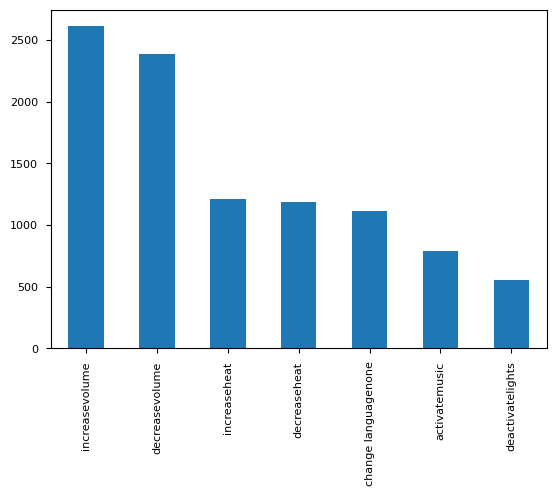

In [20]:
df["intent"].value_counts().plot.bar()

<AxesSubplot: >

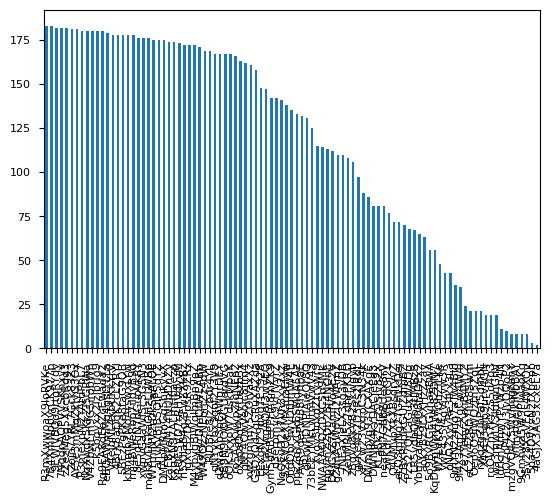

In [21]:
df["speakerId"].value_counts().plot.bar()

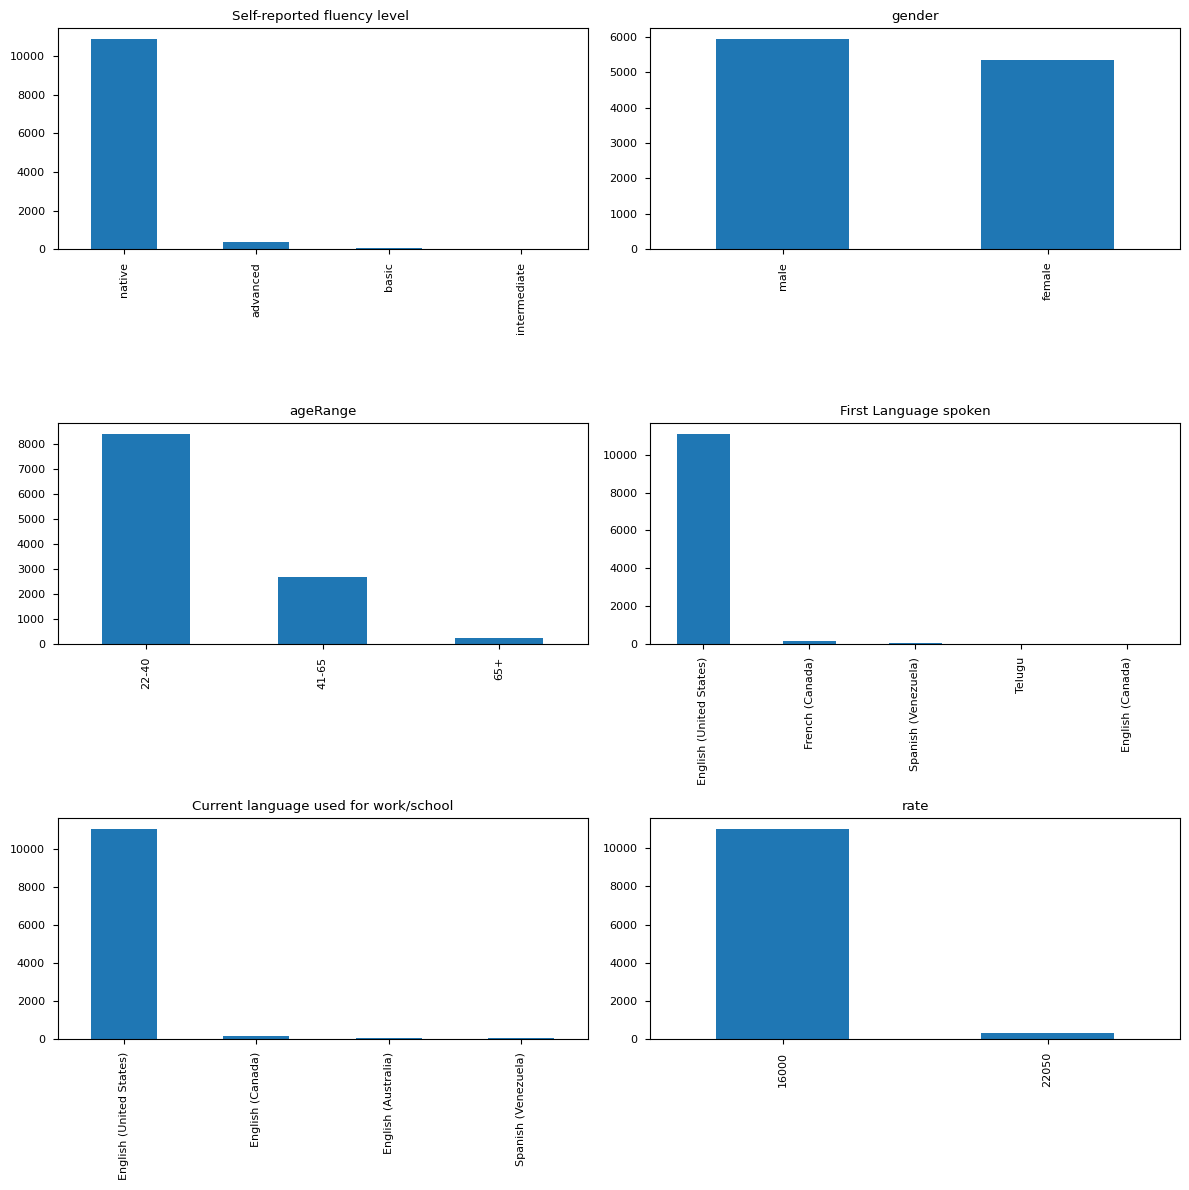

In [22]:
cols = ["Self-reported fluency level ", "First Language spoken", "Current language used for work/school", "gender", "ageRange", "rate"]
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, c in enumerate(cols):
    df[c].value_counts().plot.bar(ax=ax[i%3][i%2])
    ax[i%3][i%2].set_title(c)
plt.tight_layout()
plt.show()

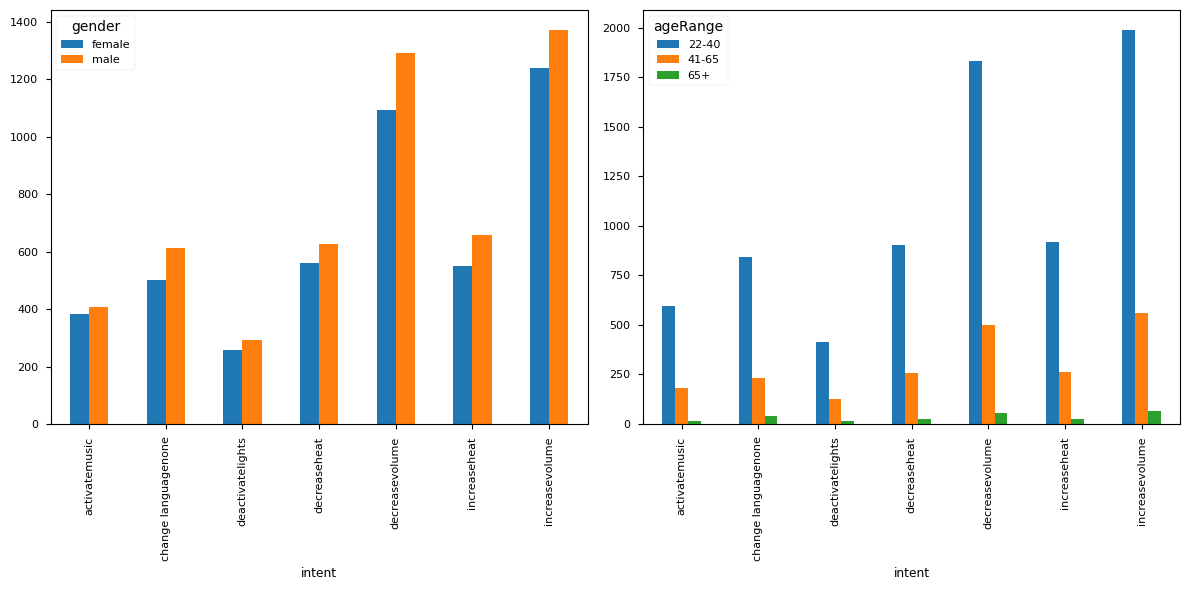

In [23]:
cols = ["gender", "ageRange"]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for i, c in enumerate(cols):
    table = pd.pivot_table(df, columns=[c], index=["intent"], values="rate", aggfunc="count")
    table.plot(kind = "bar", ax=ax[i])
plt.tight_layout()
plt.show()

Note that the majority of the speakers are native english (united states). So we could gather the others all together.      

Moreover, there are two type of sample rates.   
The distribution of the length of data is the following

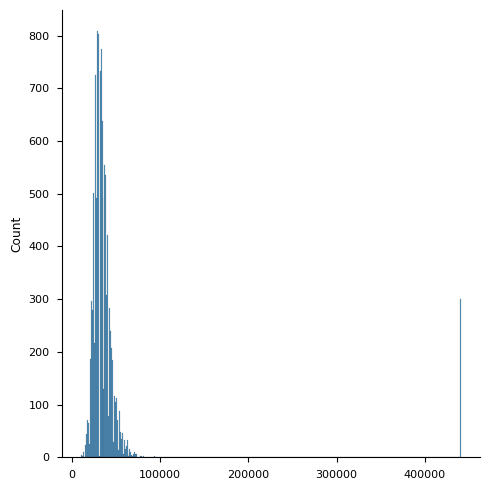

In [24]:
from seaborn import displot
displot([len(data) for data in df["data"]])

There are some same which are very long

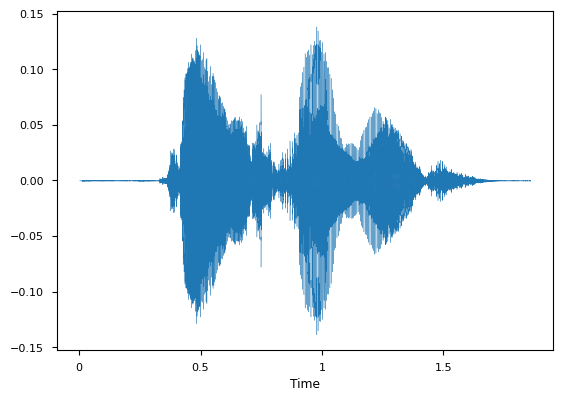

In [25]:
fig, ax = plt.subplots()
librosa.display.waveshow(df["data"][0], sr=df["rate"][0], ax=ax)

<AxesSubplot: xlabel='Time'>

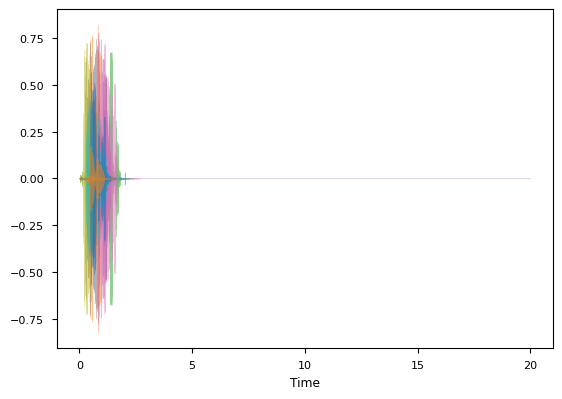

In [26]:
def plot_audio_samples(datas, rates):
    fig, ax = plt.subplots()
    for idx in range(0, len(datas), 1000):
        librosa.display.waveshow(datas[idx], sr=rates[idx], alpha=0.5, ax=ax)
    return ax

plot_audio_samples(df["data"], df["rate"])

first we can see that the signal could be normalized in order to have each amplitude in the same range.
This is done independently for each sample.

In [27]:
from scipy.stats import zscore

df["data"] = [zscore(data) for data in df["data"]]

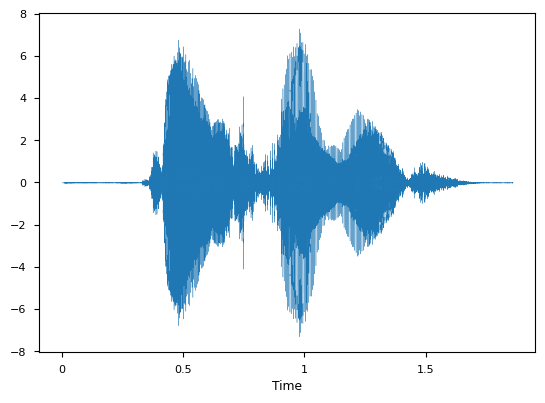

In [28]:
fig, ax = plt.subplots()
librosa.display.waveshow(df["data"][0], sr=df["rate"][0], ax=ax)

<AxesSubplot: xlabel='Time'>

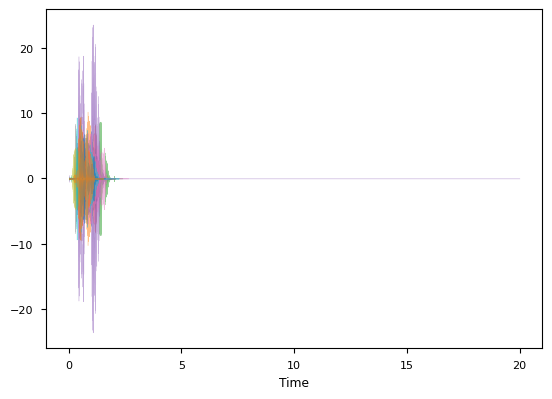

In [29]:
plot_audio_samples(df["data"], df["rate"])

We should pad and cut to have the same length for each audio. Thus, we get the same number of features for each sample

The 95% of the data has length lower or equal to 55979.


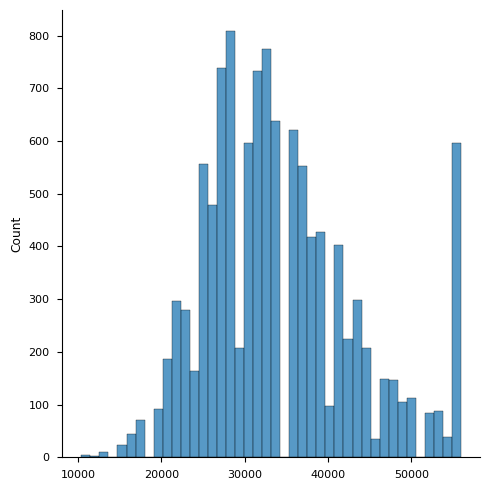

In [30]:
lengths = [len(data) for data in df["data"]]
perc = 95
length_95_perc = int(np.ceil(np.percentile(lengths, perc)))
print(f"The {perc}% of the data has length lower or equal to {length_95_perc}.")

df["data"] = [data[:length_95_perc] for data in df["data"]]
displot([len(data) for data in df["data"]])

Now, we add padding at the end in order to have equal lenght.
We add some  zeros, which represents silence

In [31]:
df["data"] = [np.pad(data, (0,length_95_perc-len(data)), constant_values=0.0) for data in df["data"]]

Let's extract the Mel-frequency cepstral coefficients (MFCCs) using the `librosa.feature.mfcc()` function.

In [32]:
# mfccs = [librosa.feature.mfcc(y=data, sr=rate) for data, rate in zip(df["data"], df["rate"])]
# mfccs[0].shape, mfccs[1].shape, mfccs[2].shape

we get the spectogram using the function `librosa.stft`, which stands for Short-time Fourier transform (STFT).
It represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.
`n_ftt` is the length of the windowed signal after padding with zeros. The suggested value for speech recognition is 512.

In [33]:
# spects = [librosa.stft(data, n_fft=512) for data in df["data"]]
# spects[0].shape, spects[1].shape, spects[3].shape

Note that, while the first dimension is constant because it refers to the frequency, the second is not. That is because it represents the time.
Therefore, if we would like to sample statistics for boxes of the spectogram, we should add padding to have all the same time length, or change the size of the boxes for each spectogram.

We will use the logarithmic scale on the y axis

In [34]:
# fig, ax = plt.subplots()
# img = librosa.display.specshow(np.abs(spects[0]), x_axis='time', y_axis='log', ax=ax)
# fig.colorbar(img, ax=ax, format="%+2.f dB")

Observe that there are not much infos. Thus it is better to convert the amplitude into decibel. The conversion is logarithmic and reflect the human perception of sounds. Thus, it creates more informative and coherent datas.

In [35]:
# spects_db = [librosa.amplitude_to_db(np.abs(spect), ref=np.max) for spect in spects]
# spects_db[0].shape, spects_db[1].shape, spects_db[3].shape

Same reasonment as before regarding the data shapes.

In [36]:
# fig, ax = plt.subplots()
# img = librosa.display.specshow(spects_db[0], x_axis='time', y_axis='log', ax=ax)
# fig.colorbar(img, ax=ax, format="%+2.0f dB")

Studies have shown that humans do not perceive frequencies on a linear scale. The mel scale have been build to represents how we perceive frequencies. A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.

In [37]:
mel_spects = [librosa.feature.melspectrogram(y=data, n_fft=512) for data in df["data"]]
mel_spects_db = [librosa.power_to_db(mel_spect, ref=np.max) for mel_spect in mel_spects]
mel_spects_db[0].shape, mel_spects_db[1].shape, mel_spects_db[3].shape

((128, 110), (128, 110), (128, 110))

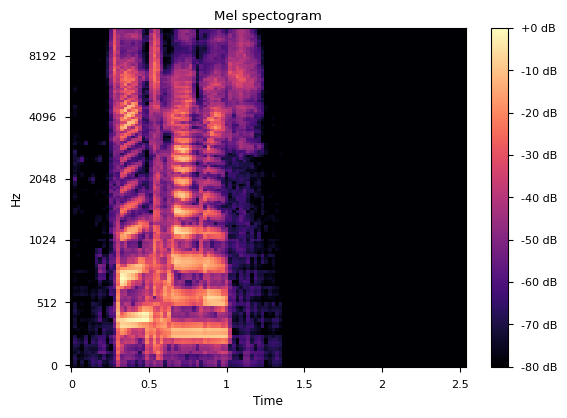

In [38]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_spects_db[0], x_axis='time', y_axis='mel', ax=ax)
ax.set(title="Mel spectogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB")

## Classify

We decide to use as decision variables just the gender, agerange, speaker id and mfccs

Since the shape of the mfcc is (20, 110), we get mean and standard deviation as values for some boxes

In [47]:
def compute_statistical_features(matrix, n = 4, m = 10):
    feat = []
    N, M = matrix.shape
    for i in range(0, N, n):
        for j in range(0, M, m):
            feat.append(np.array([
                np.mean(matrix[i:i+n, j:j+m]),
                np.std(matrix[i:i+n, j:j+m]),
                np.max(matrix[i:i+n, j:j+m]),
                np.min(matrix[i:i+n, j:j+m])
                ]))
    return np.hstack(feat)

In [41]:
mask = df["intent"].isna()
mel_spects_db = np.array(mel_spects_db)
x_dev = mel_spects_db[~mask]
y = pd.get_dummies(df["intent"][~mask])
x_eval = mel_spects_db[mask]

In [42]:
from sklearn.model_selection import train_test_split

x_train_val, x_test, y_train_val, y_test = train_test_split(x_dev, y, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.20)
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((6306, 128, 110),
 (1577, 128, 110),
 (1971, 128, 110),
 (6306, 7),
 (1577, 7),
 (1971, 7))

In [44]:
import tensorflow as tf

# define the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 110, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(7, activation='softmax')) # modify the output layer to have 7 units and softmax activation

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
model.fit(x_train_val, y_train_val, epochs=5, validation_data=(x_test, y_test))
# model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/5
247/247 [==============================] - 120s 479ms/step - loss: 3.7196 - accuracy: 0.3472 - val_loss: 1.5137 - val_accuracy: 0.4054
Epoch 2/5
247/247 [==============================] - 104s 423ms/step - loss: 1.3229 - accuracy: 0.4812 - val_loss: 1.3712 - val_accuracy: 0.4490
Epoch 3/5
247/247 [==============================] - 107s 435ms/step - loss: 1.0755 - accuracy: 0.5778 - val_loss: 1.2488 - val_accuracy: 0.5109
Epoch 4/5
247/247 [==============================] - 112s 452ms/step - loss: 0.8784 - accuracy: 0.6577 - val_loss: 1.2399 - val_accuracy: 0.5312
Epoch 5/5
247/247 [==============================] - 118s 476ms/step - loss: 0.7139 - accuracy: 0.7269 - val_loss: 1.3852 - val_accuracy: 0.5373


In [48]:
features = np.vstack([compute_statistical_features(x, 16, 11) for x in mel_spects_db])
features.shape

(11309, 320)

encode the categorical variables of our data set using one hot encoding

In [49]:
cols_to_keep = ["speakerId", "gender", "ageRange"]
cols_to_encode = ["speakerId", "gender", "ageRange"]
df_1h = pd.get_dummies(df[cols_to_keep], columns=cols_to_encode)
X = np.hstack([df_1h.values, features])
X.shape

(11309, 422)

Define the data set `X_dev` and `X_eval` which will be used for training and test. Then define `y` which are the training labels

In [50]:
mask = df["intent"].isna()
X_dev = X[~mask]
X_eval = X[mask]
y = df["intent"][~mask]
X_dev.shape, y.shape, X_eval.shape

((9854, 422), (9854,), (1455, 422))

Lets see the effect of the PCA on the new features

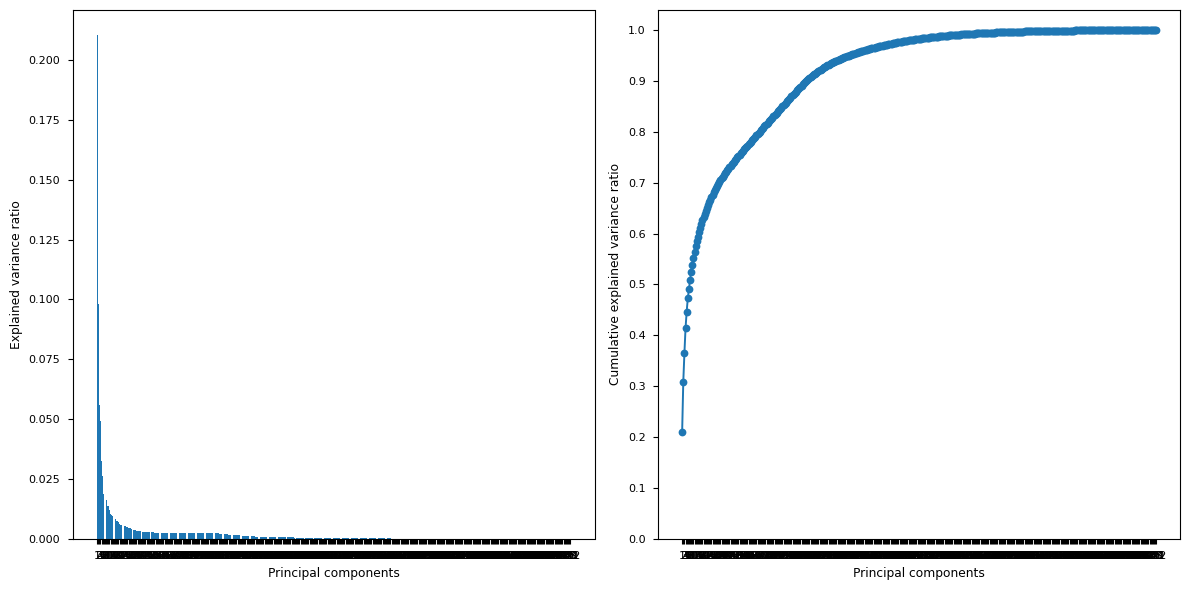

In [51]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pre = make_pipeline(
    StandardScaler(),
    PCA()
)
pca_df_scaled = pre.fit_transform(X_dev)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(range(1,len(pre["pca"].explained_variance_ratio_)+1), pre["pca"].explained_variance_ratio_)
ax[0].set_xticks(range(1,len(pre["pca"].explained_variance_ratio_)+1))
ax[0].set_xlabel("Principal components")
ax[0].set_ylabel("Explained variance ratio")
ax[1].plot(range(1,len(pre["pca"].explained_variance_ratio_)+1), pre["pca"].explained_variance_ratio_.cumsum(), marker="o")
ax[1].set_xticks(range(1,len(pre["pca"].explained_variance_ratio_)+1))
ax[1].set_xlabel("Principal components")
ax[1].set_ylabel("Cumulative explained variance ratio")
ax[1].set_yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.show()

In [52]:
qs = [0.85, 0.90, 0.95]
zs = []
for q in qs:
    z = next(x[0] for x in enumerate(pre["pca"].explained_variance_ratio_.cumsum()) if x[1] > q)
    print(f"The {q}% of the data has length lower or equal to {z}.")
    zs.append(z)

The 0.85% of the data has length lower or equal to 89.
The 0.9% of the data has length lower or equal to 111.
The 0.95% of the data has length lower or equal to 149.


function to test the various model and than the `param_grids` and `models` variables in order to make life easier.

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def test_model(model, params, X, y, cv=5, scale=False, pca=False, n_components=100):
    # Scale the data if necessary
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    # Perform PCA if necessary
    if pca:
        pca = PCA(n_components=100)
        X = pca.fit_transform(X)
    # Create a grid search object
    gs = GridSearchCV(model, params, cv=cv, scoring="accuracy")
    # Fit the model
    gs.fit(X, y)
    # Get the best model and score
    best_model = gs.best_estimator_
    best_score = gs.best_score_
    # Return the best model and score
    return best_model, best_score

    
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

param_grids = {
    "rf": {
        "n_estimators": [200],
        "max_depth": [50, 100, None]
    },
    "svc": {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 'auto']
    }
}
models = {
    "rf": RandomForestClassifier(),
    "svc": SVC()
}

In [61]:
for key, model in models.items():
    best_model, best_score = test_model(model, param_grids[key], X_dev, y, scale=True)
    print(f"""
        {best_model = }
        {best_score = }
    """)


        best_model = RandomForestClassifier(max_depth=50, n_estimators=200)
        best_score = 0.48040861527684414
    


To create the csv file that must be uploaded

In [ ]:
# y_pred = best_model.predict(X_eval)
# pd.DataFrame(y_pred, index=df["Id"][mask]).to_csv("output.csv", index_label="Id", header=["Predicted"])

In [13]:
# predict the class with the maximum probability
predictions = model.predict(x_eval)
max_prediction = predictions.argmax(axis=1)
pd.DataFrame(y.columns[max_prediction], index=df["Id"][mask]).to_csv("output.csv", index_label="Id", header=["Predicted"])

NameError: name 'model' is not defined